# <ins>C</ins>onformal <ins>Re</ins>gressors and <ins>P</ins>r<ins>e</ins>dictive <ins>S</ins>ystems (Crepes)
#### (c) Henrik Boström (bostromh@kth.se), 2021

In [4]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

from crepes import ConformalRegressor, ConformalPredictiveSystem

from crepes.fillings import (sigma_variance, 
                             sigma_variance_oob,
                             sigma_knn,
                             binning)

In [6]:
print(ConformalRegressor.evaluate.__doc__)


        Evaluate the conformal regressor.

        Parameters
        ----------
        y_hat : array-like of shape (n_values,)
            predicted (regression) values
        sigmas : array-like of shape (n_values,)
            Sigmas; difficulty estimates
        bins : array-like of shape (n_values,)
            Bins; Mondrian categories
        confidence : float in range (0,1), default = 0.95
            The confidence level.
        y_min : float or int, default = -np.inf
            The minimum value to include in prediction intervals.
        y_max : float or int, default = np.inf
            The maximum value to include in prediction intervals.
        metrics : a string or a list of strings, default = list of all metrics
            Metrics: 'error','efficiency', 'time_fit','time_evaluate'
        
        Returns
        -------
        results : dictionary with a key for each element of 'metrics' 
            Estimated performance using the metrics.
        


### 1. Import data and train underlying models

#### 1.1 Import a dataset and divide it into proper training, calibration and test sets 

Import a dataset, e.g., from www.openml.org.

In [2]:
dataset = fetch_openml(name="house_sales",version=3)

X = dataset.data.values.astype(float)
y = dataset.target.values.astype(float)

Normalize the targets (this is not really necessary, but useful, e.g., when comparing results across datasets).

In [3]:
y = np.array([(y[i]-y.min())/(y.max()-y.min()) for i in range(len(y))])

Split the dataset into a training and a test set.

In [4]:
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.5) 

Split the training set into a proper training and a calibration set.

In [5]:
X_proper_training, X_calibration, y_proper_training, y_calibration = train_test_split(X_training, y_training, test_size=0.25)

print("Total no. of instances: {}".format(X.shape[0]))
print("No. of features: {}".format(X.shape[1]))
print("No. of proper training instances: {}".format(X_proper_training.shape[0]))
print("No. of calibration instances: {}".format(X_calibration.shape[0]))
print("No. of test instances: {}".format(X_test.shape[0]))

Total no. of instances: 21613
No. of features: 21
No. of proper training instances: 8104
No. of calibration instances: 2702
No. of test instances: 10807


#### 1.2 Generate a model from the proper training set

In [6]:
tic = time.time()

learner_proper = RandomForestRegressor(n_jobs=-1, n_estimators=500, max_features=1/3) 
# Note: default for max_features = 1

learner_proper.fit(X_proper_training, y_proper_training)

toc = time.time()

print("Model generated in {:.2f} s.".format(toc - tic))

Model generated in 2.81 s.


Make predictions for the test set (to be used later).

In [7]:
y_hat_proper = learner_proper.predict(X_test)

### 2. Conformal regressors (CR)

#### 2.1 Standard conformal regressors

Create a conformal regressor.

In [8]:
cr_standard = ConformalRegressor()

We may display the object, e.g., to see whether it has been fitted or not; this particular information is stored in `cr_standard.fitted`.

In [9]:
display(cr_standard)

ConformalRegressor(fitted=False)

Let us fit the standard conformal regressor; for this we need the residuals from the calibration set. 

In [10]:
residuals_calibration = y_calibration - learner_proper.predict(X_calibration)

Now let us fit the conformal regressor.

In [11]:
cr_standard.fit(residuals=residuals_calibration)

ConformalRegressor(fitted=True, normalized=False, mondrian=False)

When inspecting the object, we can see that it has been updated.

In [12]:
display(cr_standard)

ConformalRegressor(fitted=True, normalized=False, mondrian=False)

Since the conformal regressor has been fitted, we may now obtain
prediction intervals from the point predictions for the test set; 
here using a confidence level of 99%.

In [13]:
intervals = cr_standard.predict(y_hat=y_hat_proper, confidence=0.99)

display(intervals)

array([[ 0.09490188,  0.25270052],
       [-0.01997933,  0.13781931],
       [ 0.05793062,  0.21572926],
       ...,
       [-0.02354015,  0.13425849],
       [-0.04360046,  0.11419818],
       [-0.0183429 ,  0.13945574]])

We may request that the intervals are cut to exclude impossible values, in this case below 0 and above 1; below we also use the default 
confidence level (95%), which further tightens the intervals.

In [14]:
intervals_standard = cr_standard.predict(y_hat=y_hat_proper, y_min=0, y_max=1)

display(intervals_standard)

array([[0.14294794, 0.20465445],
       [0.02806674, 0.08977324],
       [0.10597669, 0.16768319],
       ...,
       [0.02450592, 0.08621243],
       [0.00444561, 0.06615211],
       [0.02970316, 0.09140967]])

#### 2.2 Normalized conformal regressors

The above intervals are not normalized, i.e., they are all of the same size (at least before they are cut).

We could make the intervals more informative through normalization using difficulty estimates; 
more difficult instances will be assigned wider intervals.
Here we will use the helper functions `sigma_knn` and `sigma_variance` for this purpose. 
The former estimates the difficulty by the mean absolute errors of the k nearest neighbors to each instance in the calibration set.
The latter can be used with ensemble learners only, and estimates the difficulty by the variance of 
the predictions of the constituent models. A small value (beta) is added to the estimates, 
which may be given through a (named) argument to the functions; below we just use the default, i.e., `beta=0.01`.

Note: the function `sigma_variance` assumes that `learner.estimators_` is a collection of base models, each implementing the `predict` method; this holds e.g., for `RandomForestRegressor`.

In [15]:
sigmas_calibration_knn = sigma_knn(X=X_calibration, residuals=residuals_calibration)

cr_normalized_knn = ConformalRegressor()
cr_normalized_knn.fit(residuals=residuals_calibration, sigmas=sigmas_calibration_knn)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

In [16]:
sigmas_calibration_var = sigma_variance(X=X_calibration, learner=learner_proper)

cr_normalized_var = ConformalRegressor()
cr_normalized_var.fit(residuals=residuals_calibration, sigmas=sigmas_calibration_var)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

To generate prediction intervals for the test set, we need difficulty estimates for the latter too. For `sigma_knn` we now have to specify what calibration objects and residuals should be used for estimating the difficulty of the test set. For `sigma_variance` we do not need to provide any information from the calibration set.

In [17]:
sigmas_test_knn = sigma_knn(X=X_calibration, residuals=residuals_calibration, X_test=X_test)

intervals_normalized_knn = cr_normalized_knn.predict(y_hat=y_hat_proper, sigmas=sigmas_test_knn, y_min=0, y_max=1)

display(intervals_normalized_knn)

array([[0.11550115, 0.23210124],
       [0.02547954, 0.09236044],
       [0.10069275, 0.17296712],
       ...,
       [0.03814564, 0.07257271],
       [0.0147817 , 0.05581603],
       [0.03638322, 0.08472961]])

In [18]:
sigmas_test_var = sigma_variance(X=X_test, learner=learner_proper)

intervals_normalized_var = cr_normalized_var.predict(y_hat=y_hat_proper, sigmas=sigmas_test_var, y_min=0, y_max=1)

display(intervals_normalized_var)

array([[0.13070357, 0.21689883],
       [0.03012185, 0.08771814],
       [0.10553363, 0.16812625],
       ...,
       [0.02777266, 0.08294569],
       [0.00761991, 0.06297781],
       [0.03269478, 0.08841805]])

#### 2.3 Standard conformal regressors with out-of-bag calibration

For learners that employ bagging, like random forests, we may employ an alternative to dividing the original training set into a proper training and calibration set; we may use the out-of-bag (OOB) predictions, which allow us to use the full training set 
for both model building and calibration.

Let us first generate a model from the full training set and then get the residuals using the OOB predictions; the latter assumes that the learner has an attribute `oob_prediction_`, which e.g. is the case for a `RandomForestRegressor` if `oob_score` is set to `True` when created.

In [19]:
tic = time.time()

learner_full = RandomForestRegressor(n_jobs=-1, n_estimators=500, max_features=1/3, oob_score=True) 
# Note: default for max_features = no. features

learner_full.fit(X_training, y_training)

toc = time.time()

print('Model generated in {:.2f} s.'.format(toc - tic))

Model generated in 4.24 s.


Now we can obtain the residuals

In [20]:
residuals_oob = y_training-learner_full.oob_prediction_

Make predictions for the test set (to be used later).

In [21]:
y_hat_full = learner_full.predict(X_test)

We may now obtain a standard conformal regressor from these OOB residuals

In [22]:
cr_standard_oob = ConformalRegressor()
cr_standard_oob.fit(residuals=residuals_oob)

ConformalRegressor(fitted=True, normalized=False, mondrian=False)

... and apply it using the predictions of the full model.

In [23]:
intervals_standard_oob = cr_standard_oob.predict(y_hat=y_hat_full, y_min=0, y_max=1)

display(cr_standard_oob)

display(intervals_standard_oob)

ConformalRegressor(fitted=True, normalized=False, mondrian=False)

array([[0.14967329, 0.21023162],
       [0.02948758, 0.09004591],
       [0.11070587, 0.1712642 ],
       ...,
       [0.02253432, 0.08309265],
       [0.00473313, 0.06529146],
       [0.03064917, 0.0912075 ]])

#### 2.4 Normalized conformal regressors with out-of-bag calibration

We may also generate normalized conformal regressors from the OOB predictions.
The helper function `sigma_knn` can just as well be used together with the OOB residuals.

In [24]:
sigmas_oob_knn = sigma_knn(X=X_training, residuals=residuals_oob)

cr_normalized_knn_oob = ConformalRegressor()
cr_normalized_knn_oob.fit(residuals=residuals_oob, sigmas=sigmas_oob_knn)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

If we want to use variance as a difficulty estimate, we may use the helper function 
`sigma_variance_oob`, which as before requires that `learner.oob_prediction_` and 
`learner.estimators_` have been defined. The default value for `beta` (`= 0.01`) is used again.

In [25]:
sigmas_oob_var = sigma_variance_oob(X=X_training, learner=learner_full)

cr_normalized_var_oob = ConformalRegressor()
cr_normalized_var_oob.fit(residuals=residuals_oob, sigmas=sigmas_oob_var)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

In order to apply the normalized OOB regressors to the test set, we
need to generate difficulty estimates for the latter in the same way

In [26]:
sigmas_test_knn_oob = sigma_knn(X=X_training, residuals=residuals_oob, X_test=X_test)

intervals_normalized_knn_oob = cr_normalized_knn_oob.predict(y_hat=y_hat_full, sigmas=sigmas_test_knn_oob, 
                                                             y_min=0, y_max=1)
display(intervals_normalized_knn_oob)

array([[0.11977521, 0.2401297 ],
       [0.02532477, 0.09420872],
       [0.11063834, 0.17133174],
       ...,
       [0.03360102, 0.07202594],
       [0.01205823, 0.05796636],
       [0.04087834, 0.08097832]])

In [27]:
sigmas_test_var_oob = sigma_variance_oob(X=X_test, learner=learner_full)

intervals_normalized_var_oob = cr_normalized_var_oob.predict(y_hat=y_hat_full, sigmas=sigmas_test_var_oob, 
                                                             y_min=0, y_max=1)

display(intervals_normalized_var_oob)

array([[0.1364841 , 0.22342081],
       [0.03173405, 0.08779945],
       [0.11148556, 0.17048452],
       ...,
       [0.02620094, 0.07942602],
       [0.00830151, 0.06172307],
       [0.03413342, 0.08772325]])

#### 2.5 Mondrian conformal regressors

An alternative way of generating prediction intervals of varying size
is to divide the object space into non-overlapping so-called Mondrian categories.
A Mondrian conformal regressor is formed by providing the names of the categories
as an additional argument, named `bins`, for the `fit` method.

Here we employ the helper function `binning`, which given a list/array of values
assignes the values into named bins. If the optional named argument `bins` is an
integer, the function will divide the values into equal-sized bins and return
both the assigned bins and the bin boundaries. If `bins` instead is a set of
bin boundaries, the function will just return the assigned bins.

We can form the Mondrian categories in almost any way we like (as long as we do
not use the labels), and here we will use binning of difficulty estimates

In [28]:
bins_calibration, bin_borders = binning(values=sigmas_calibration_knn, bins=20)

cr_mondrian = ConformalRegressor()
cr_mondrian.fit(residuals=residuals_calibration, bins=bins_calibration)

ConformalRegressor(fitted=True, normalized=False, mondrian=True)

Let us now obtain the categories for the test instances using the
same Mondrian categorization, i.e., bin borders.

In [29]:
bins_test = binning(values=sigmas_test_knn, bins=bin_borders)

... and now we can form prediction intervals for the test instances.

In [30]:
intervals_mondrian = cr_mondrian.predict(y_hat=y_hat_proper, bins=bins_test, y_min=0, y_max=1)

display(intervals_mondrian)

array([[0.04666372, 0.30093867],
       [0.02484729, 0.09299269],
       [0.07397296, 0.19968692],
       ...,
       [0.04173161, 0.06898673],
       [0.01623236, 0.05436537],
       [0.03843034, 0.08268249]])

#### 2.6 Mondrian conformal regressors with out-of-bag calibration

We now form the categories using the difficulty estimates obtained from the OOB predictions

In [31]:
bins_oob, bin_borders_oob = binning(values=sigmas_oob_knn, bins=20)

cr_mondrian_oob = ConformalRegressor()
cr_mondrian_oob.fit(residuals_oob, bins=bins_oob)

ConformalRegressor(fitted=True, normalized=False, mondrian=True)

... and find the categories for the test instances, ...

In [32]:
bins_test_oob = binning(values=sigmas_test_knn_oob, bins=bin_borders_oob)

... and finally generate the prediction intervals.

In [33]:
intervals_mondrian_oob = cr_mondrian_oob.predict(y_hat_full, bins=bins_test_oob, y_min=0, y_max=1)

display(intervals_mondrian_oob)

array([[0.06300232, 0.2969026 ],
       [0.0137715 , 0.105762  ],
       [0.10321978, 0.17875029],
       ...,
       [0.03770574, 0.06792122],
       [0.01241655, 0.05760804],
       [0.04310481, 0.07875186]])

#### 2.7 Investigating the prediction intervals

Let us first put all the intervals in a dictionary.

In [34]:
prediction_intervals = {
    "Standard CR":intervals_standard,
    "Standard OOB CR":intervals_standard_oob,
    "Norm. CR knn":intervals_normalized_knn,
    "Norm. OOB CR knn":intervals_normalized_knn_oob,
    "Norm. CR var":intervals_normalized_var,
    "Norm. OOB CR var":intervals_normalized_var_oob,
    "Mondrian CR":intervals_mondrian,
    "Mondrian OOB CR":intervals_mondrian_oob
}

Let us see what fraction of the intervals that contain the true targets and how large the intervals are.

In [59]:
coverages = []
sizes = []

for name in prediction_intervals.keys():
    intervals = prediction_intervals[name]
    coverages.append(np.sum([1 if (y_test[i]>=intervals[i,0] and y_test[i]<=intervals[i,1]) else 0 
                            for i in range(len(y_test))])/len(y_test))
    sizes.append((intervals[:,1]-intervals[:,0]).mean())

pred_int_df = pd.DataFrame({"Coverage":coverages, "Size":sizes}, index=list(prediction_intervals.keys()))
pred_int_df.loc["Mean"] = [pred_int_df["Coverage"].mean(), pred_int_df["Size"].mean()]

display(pred_int_df.round(4))

,Coverage,Size
Standard CR,0.9476,0.0603
Standard OOB CR,0.9491,0.0593
Norm. CR knn,0.9477,0.0516
Norm. OOB CR knn,0.9468,0.0512
Norm. CR var,0.9523,0.0572
Norm. OOB CR var,0.9485,0.0551
Mondrian CR,0.9515,0.0582
Mondrian OOB CR,0.9479,0.0576
Mean,0.9489,0.0563


Let us look at the distribution of the interval sizes.

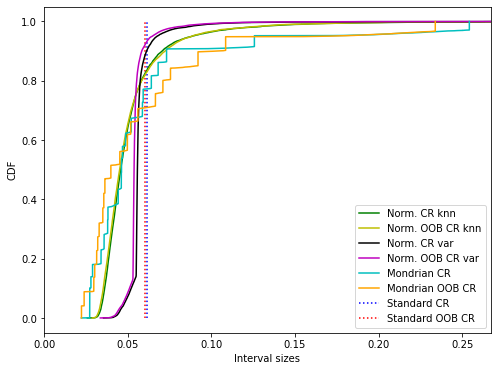

In [36]:
interval_sizes = {}
for name in prediction_intervals.keys():
    interval_sizes[name] = prediction_intervals[name][:,1]-prediction_intervals[name][:,0]

plt.figure(figsize=(8,6))
plt.ylabel("CDF")
plt.xlabel("Interval sizes")
plt.xlim(0,interval_sizes["Mondrian CR"].max()*1.05)

colors = ["b","r","g","y","k","m","c","orange"]

for i, name in enumerate(prediction_intervals.keys()):
    
    if "Standard" in name:
        plt.vlines(interval_sizes[name][0],0,1,linestyles="dotted",colors=colors[i],label=name)
    else:
        plt.plot(np.sort(interval_sizes[name]),[i/len(interval_sizes[name]) 
                                                for i in range(1,len(interval_sizes[name])+1)],
         c=colors[i],label=name)

plt.legend()

plt.show()

Here is another view of the prediction intervals.

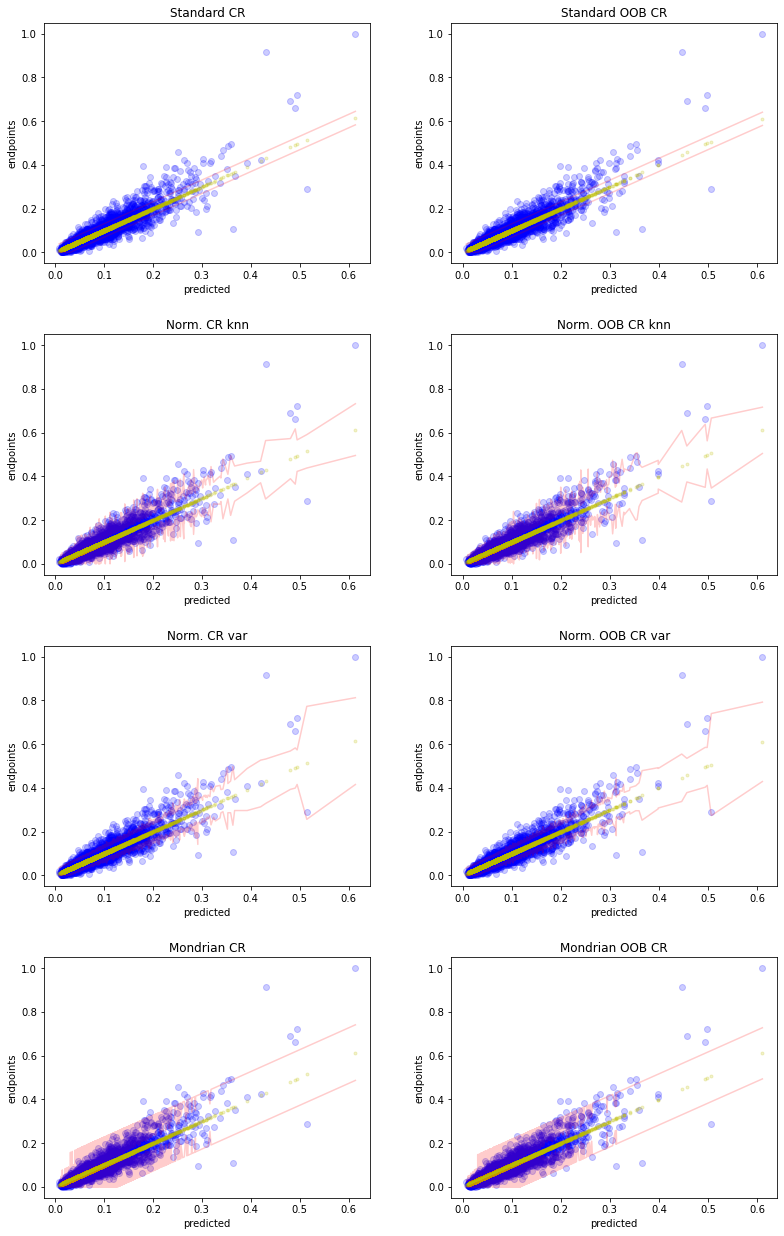

In [37]:
figure, axes = plt.subplots(4,2,figsize=(12,18))
figure.tight_layout(pad=5.0)

sorted_prop_indexes = np.argsort(y_hat_proper) # This is just to get the lineplots for the  
                                                           # normalized versions to look fine
sorted_full_indexes = np.argsort(y_hat_full) 

alpha=0.2

for i, name in enumerate(prediction_intervals.keys()):

    plt.subplot(4,2,i+1)
    if "OOB" in name:
        indexes = sorted_full_indexes
        y_hat = y_hat_full
    else:
        indexes = sorted_prop_indexes
        y_hat = y_hat_proper

    plt.title(name)
    plt.plot(y_hat[indexes], prediction_intervals[name][indexes,0], color="r", alpha=alpha)
    plt.plot(y_hat[indexes], prediction_intervals[name][indexes,1], color="r", alpha=alpha)
    plt.scatter(y_hat[indexes],y_test[indexes],color="b",marker="o",alpha=0.2)
    plt.scatter(y_hat[indexes],y_hat[indexes],color="y",marker=".",alpha=0.2)
    plt.xlabel("predicted")
    plt.ylabel("endpoints")

plt.show()

#### 2.8 Evaluating the conformal regressors

Let us put six of the above conformal regressors in a dictionary

In [38]:
all_cr = {
    "Standard CR":cr_standard,
    "Normalized CR":cr_normalized_knn,
    "Standard OOB CR":cr_standard_oob,
    "Normalized OOB CR":cr_normalized_knn_oob,
    "Mondrian CR":cr_mondrian,
    "Mondrian OOB CR":cr_mondrian_oob
}

Let us evaluate them using three confidence levels on the test set.
We could specify a subset of the metrics to use by the named
`metrics` argument of the `evaluate` method; here we use all, 
which is the default.

Note that the arguments `sigmas` and `bins` can always be provided,
but they will be ignored by conformal regressors not using them,
e.g., both arguments will be ignored by the standard conformal regressors.

In [39]:
confidence_levels = [0.9,0.95,0.99]

names = list(all_cr.keys())
all_results = {}

for confidence in confidence_levels:
    for name in names:
        if "OOB" in name:
            all_results[(name,confidence)] = all_cr[name].evaluate(y_hat=y_hat_full, 
                                                                   y=y_test, sigmas=sigmas_test_knn_oob,
                                                                   bins=bins_test_oob,
                                                                   confidence=confidence, y_min=0, y_max=1)
        else:
            all_results[(name,confidence)] = all_cr[name].evaluate(y_hat=y_hat_proper, 
                                                                   y=y_test, sigmas=sigmas_test_knn,
                                                                   bins=bins_test,
                                                                   confidence=confidence, y_min=0, y_max=1)

results_df = pd.DataFrame(columns=pd.MultiIndex.from_product([names,confidence_levels]),
                          index=list(list(all_results.values())[0].keys()))

for key in all_results.keys():
    results_df[key] = all_results[key].values()

display(results_df.round(4))

Standard CR                 Normalized CR                  \
                     0.90    0.95    0.99          0.90    0.95    0.99   
error              0.1005  0.0524  0.0077        0.1046  0.0523  0.0117   
efficiency         0.0421  0.0603  0.1314        0.0382  0.0516  0.0886   
time_fit           0.0004  0.0004  0.0004        0.0002  0.0002  0.0002   
time_evaluate      0.0004  0.0002  0.0002        0.0002  0.0002  0.0003   

              Standard OOB CR                 Normalized OOB CR          \
                         0.90    0.95    0.99              0.90    0.95   
error                  0.1053  0.0509  0.0092            0.1056  0.0532   
efficiency             0.0399  0.0593  0.1233            0.0378  0.0512   
time_fit               0.0011  0.0011  0.0011            0.0006  0.0006   
time_evaluate          0.0002  0.0002  0.0002            0.0002  0.0002   

                      Mondrian CR                 Mondrian OOB CR          \
                 0.99        0.90    0.95    0.99            0.90    0.95   
error          0.0096      0.0944  0.0485  0.0083          0.1035  0.0521   
efficiency     0.0916      0.0437  0.0582  0.1091          0.0417  0.0576   
time_fit       0.0006      0.0008  0.0008  0.0008          0.0017  0.0017   
time_evaluate  0.0002      0.0011  0.0011  0.0012          0.0011  0.0010   

                       
                 0.99  
error          0.0084  
efficiency     0.0967  
time_fit       0.0017  
time_evaluate  0.0013

### 3. Conformal Predictive Systems (CPS)

#### 3.1 Create and fit a standard CPS

Let us create a `ConformalPredictiveSystem` object.

In [40]:
cps_standard = ConformalPredictiveSystem()

Fit the conformal predictive system in the same way as a standard conformal regressor (see above).

In [41]:
cps_standard.fit(residuals=residuals_calibration)

ConformalPredictiveSystem(fitted=True, normalized=False, mondrian=False)

#### 3.2 Create and fit a normalized CPS

In [42]:
cps_normalized = ConformalPredictiveSystem()

Fit it in the same way as a normalized conformal regressor (see above)

In [43]:
cps_normalized.fit(residuals=residuals_calibration, sigmas=sigmas_calibration_knn)

ConformalPredictiveSystem(fitted=True, normalized=True, mondrian=False)

#### 3.3 Create and fit a standard CPS with out-of-bag calibration

In [44]:
cps_standard_oob = ConformalPredictiveSystem()

Fit it using the OOB residuals.

In [45]:
cps_standard_oob.fit(residuals=residuals_oob)

ConformalPredictiveSystem(fitted=True, normalized=False, mondrian=False)

#### 3.4 Create and fit a normalized CPS with out-of-bag calibration

In [46]:
cps_normalized_oob = ConformalPredictiveSystem()

Fit it using the OOB residuals and sigmas.

In [47]:
cps_normalized_oob.fit(residuals=residuals_oob, sigmas=sigmas_oob_knn)

ConformalPredictiveSystem(fitted=True, normalized=True, mondrian=False)

#### 3.5 Create and fit a Mondrian CPS with normalization

Here we form the Mondrian categories by binning the predictions on the calibration set.

In [48]:
cps_bins_calibration, cps_bin_borders = binning(values=learner_proper.predict(X_calibration), bins=5)

By providing difficulty estimates (sigmas), normalization within each category will be done. 

In [49]:
cps_mondrian = ConformalPredictiveSystem()
cps_mondrian.fit(residuals=residuals_calibration, sigmas=sigmas_calibration_knn, bins=cps_bins_calibration)

ConformalPredictiveSystem(fitted=True, normalized=True, mondrian=True)

#### 3.6 Create and fit a Mondrian CPS with out-of-bag calibration

Here we form the Mondrian categories by binning the OOB predictions of the full learner.
Again, we employ normalization.

In [50]:
cps_bins_oob, cps_bin_borders_oob = binning(values=learner_full.oob_prediction_, bins=5)

cps_mondrian_oob = ConformalPredictiveSystem()
cps_mondrian_oob.fit(residuals=residuals_oob, sigmas=sigmas_oob_knn, bins=cps_bins_oob)

ConformalPredictiveSystem(fitted=True, normalized=True, mondrian=True)

#### 3.7 Make predictions and analyze the p-values

Let us put all the created and fitted CPS in a dictionary.

In [51]:
all_cps = {"Standard CPS":cps_standard,
           "Standard OOB CPS":cps_standard_oob,
           "Normalized CPS":cps_normalized,
           "Normalized OOB CPS":cps_normalized_oob,
           "Mondrian Normalized CPS":cps_mondrian,
           "Mondrian Normalized OOB CPS":cps_mondrian_oob
          }

For the Mondrian approaches, we need the categories for the test instances.

In [52]:
cps_test_bins = binning(values=y_hat_proper, bins=cps_bin_borders)
cps_test_bins_oob = binning(values=y_hat_full, bins=cps_bin_borders_oob)

Checking that the p-values for the test targets appear to be uniformly distributed.

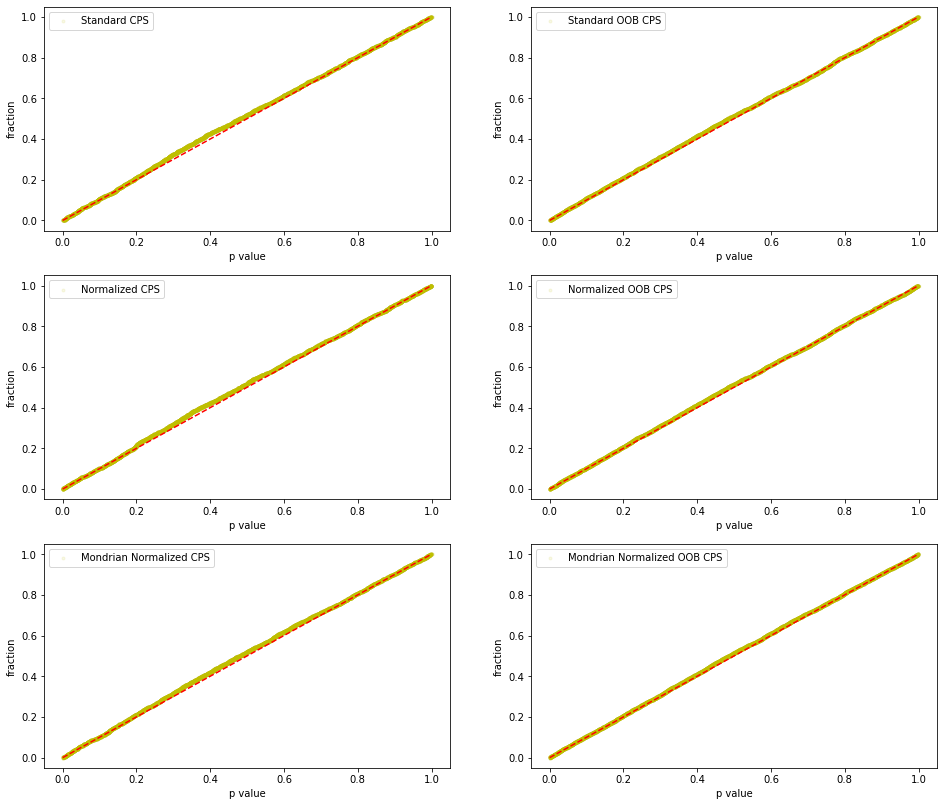

In [53]:
plt.subplots(3,2,figsize=(16,14))

for i, name in enumerate(all_cps.keys()):

    if "OOB" in name:
        p_values = all_cps[name].predict(y_hat=y_hat_full, sigmas=sigmas_test_knn_oob, bins=cps_test_bins_oob, y=y_test)[:,0]
    else:
        p_values = all_cps[name].predict(y_hat=y_hat_proper, sigmas=sigmas_test_knn, bins=cps_test_bins, y=y_test)[:,0]

    plt.subplot(3,2,i+1)

    plt.scatter(np.sort(p_values),[(i+1)/len(y_test) for i in range(len(y_test))],label=name,c="y",marker=".",alpha=0.1)
    plt.plot([0,1],[0,1],"r--")
    plt.legend()
    plt.ylabel("fraction")
    plt.xlabel("p value")

plt.show()

#### 3.8 Investigate the coverage and size of extracted prediction intervals

Let us investigate the extracted prediction intervals at the 95% confidence level. 
This is done by a specifying percentiles corresponding to the interval endpoints, where
`lower_percentiles` denotes (one or more) percentiles for which a lower value
will be selected in case a percentile lies between two values
(similar to `interpolation="lower"` in `numpy.percentile`), and
`higher_percentiles` denotes (one or more) percentiles for which a higher value
will be selected in such cases (similar to `interpolation="higher"` in `numpy.percentile`).

In [60]:
all_cps_intervals = {}

coverages = []
sizes = []

for name in all_cps.keys():
    if "OOB" in name:
        intervals = all_cps[name].predict(y_hat=y_hat_full, sigmas=sigmas_test_knn_oob, 
                                          bins=cps_test_bins_oob,
                                          lower_percentiles=2.5, higher_percentiles=97.5,
                                          y_min=0, y_max=1)
    else:
        intervals = all_cps[name].predict(y_hat=y_hat_proper, sigmas=sigmas_test_knn, 
                                          bins=cps_test_bins,
                                          lower_percentiles=2.5, higher_percentiles=97.5,
                                          y_min=0, y_max=1)
    all_cps_intervals[name] = intervals
    coverages.append(np.sum([1 if (y_test[i]>=intervals[i,0] and y_test[i]<=intervals[i,1]) else 0 
                            for i in range(len(y_test))])/len(y_test))
    sizes.append((intervals[:,1]-intervals[:,0]).mean())

pred_int_df = pd.DataFrame({"Coverage":coverages, "Size":sizes}, index=list(all_cps.keys()))
pred_int_df.loc["Mean"] = [pred_int_df["Coverage"].mean(), pred_int_df["Size"].mean()]

display(pred_int_df.round(4))

,Coverage,Size
Standard CPS,0.9519,0.0646
Standard OOB CPS,0.9482,0.0608
Normalized CPS,0.9456,0.0521
Normalized OOB CPS,0.9459,0.0513
Mondrian Normalized CPS,0.9486,0.0541
Mondrian Normalized OOB CPS,0.9466,0.0551
Mean,0.9478,0.0563


#### 3.9 Investigate the distributions of extracted prediction intervals

Let us take a look at the distribution of the interval sizes.

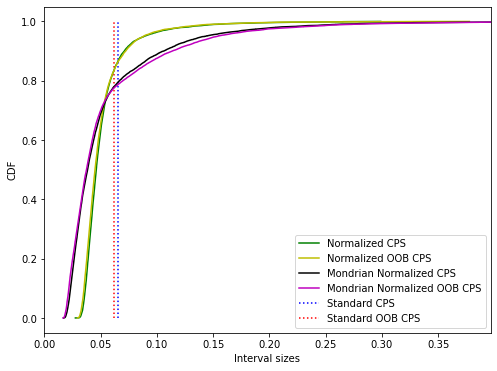

In [61]:
cps_interval_sizes = {}
for name in all_cps_intervals.keys():
    cps_interval_sizes[name] = all_cps_intervals[name][:,1]-all_cps_intervals[name][:,0]

plt.figure(figsize=(8,6))
plt.ylabel("CDF")
plt.xlabel("Interval sizes")
plt.xlim(0,cps_interval_sizes["Normalized OOB CPS"].max()*1.05)

colors = ["b","r","g","y","k","m"]

for i, name in enumerate(cps_interval_sizes.keys()):
    
    if "Standard" in name:
        plt.vlines(cps_interval_sizes[name][0],0,1,linestyles="dotted",colors=colors[i],label=name)
    else:
        plt.plot(np.sort(cps_interval_sizes[name]),[i/len(cps_interval_sizes[name]) 
                                                for i in range(1,len(cps_interval_sizes[name])+1)],
         c=colors[i],label=name)

plt.legend()

plt.show()

#### 3.10 Extracting medians

Let us take a look at the medians; they can be derived using either lower or higher interpolation,
but ideally the differences should be small.

In [62]:
all_cps_medians = {}

for name in all_cps.keys():
    if "OOB" in name:
        medians = all_cps[name].predict(y_hat=y_hat_full, sigmas=sigmas_test_knn_oob, 
                                        bins=cps_test_bins_oob,
                                        lower_percentiles=50, higher_percentiles=50)
    else:
        medians = all_cps[name].predict(y_hat=y_hat_proper, sigmas=sigmas_test_knn, 
                                        bins=cps_test_bins,
                                        lower_percentiles=50, higher_percentiles=50)
    all_cps_medians[name] = medians
    print(name)
    print("\tMean median difference:    {:.6f}".format((medians[:,1]-medians[:,0]).mean()))
    print("\tLargest median difference: {:.6f}".format((medians[:,1]-medians[:,0]).max()))

Standard CPS
	Mean median difference:    0.000003
	Largest median difference: 0.000003
Standard OOB CPS
	Mean median difference:    0.000005
	Largest median difference: 0.000005
Normalized CPS
	Mean median difference:    0.000003
	Largest median difference: 0.000019
Normalized OOB CPS
	Mean median difference:    0.000000
	Largest median difference: 0.000003
Mondrian Normalized CPS
	Mean median difference:    0.000031
	Largest median difference: 0.000325
Mondrian Normalized OOB CPS
	Mean median difference:    0.000000
	Largest median difference: 0.000000


#### 3.11 Another view of the medians and prediction intervals

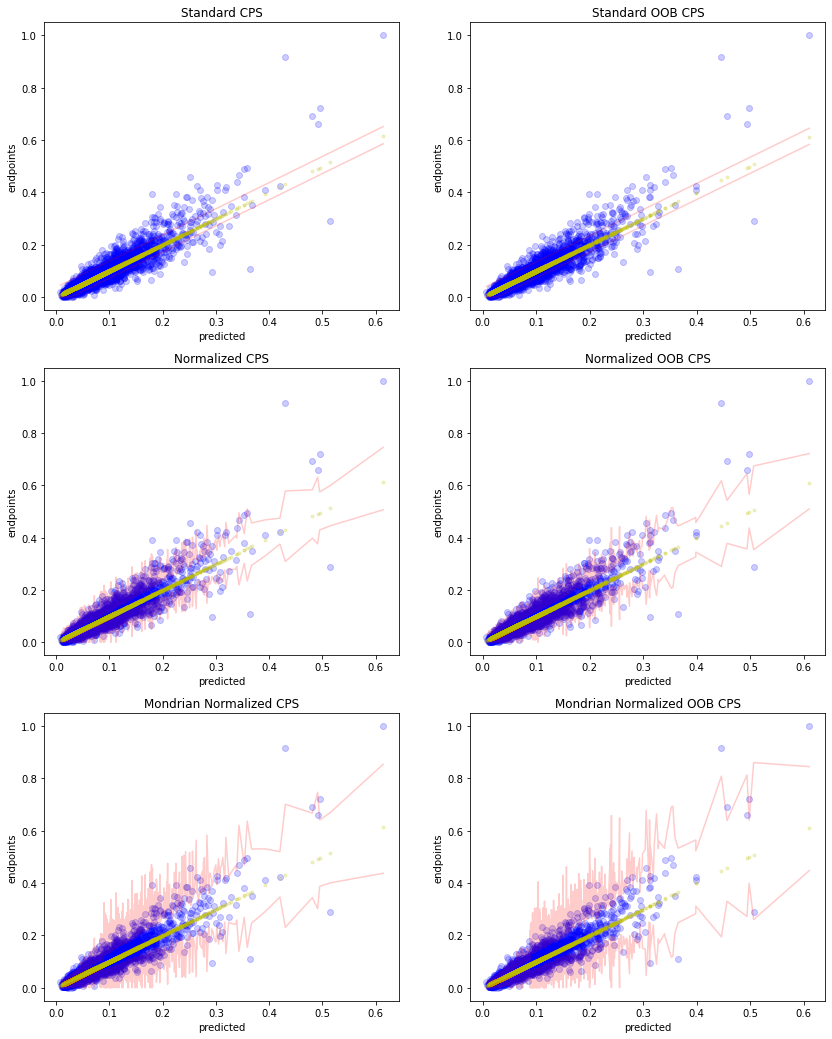

In [63]:
plt.subplots(3,2,figsize=(14,18))

sorted_prop_indexes = np.argsort(y_hat_proper) # This is just to get the lineplots for the  
                                                           # normalized versions to look fine
sorted_full_indexes = np.argsort(y_hat_full) 

alpha=0.2

for i, name in enumerate(all_cps_intervals.keys()):

    plt.subplot(3,2,i+1)
    if "OOB" in name:
        indexes = sorted_full_indexes
        y_hat = y_hat_full
    else:
        indexes = sorted_prop_indexes
        y_hat = y_hat_proper

    plt.title(name)
    plt.plot(y_hat[indexes], all_cps_intervals[name][indexes,0], color="r", alpha=alpha)
    plt.plot(y_hat[indexes], all_cps_intervals[name][indexes,1], color="r", alpha=alpha)
    plt.scatter(y_hat[indexes],y_test[indexes],color="b",marker="o",alpha=0.2)
    plt.scatter(y_hat[indexes],y_hat[indexes],color="y",marker=".",alpha=0.2)
    plt.xlabel("predicted")
    plt.ylabel("endpoints")

plt.show()

#### 3.12 Investigating some conformal predictive distributions

Let us take a look at the conformal predictive distributions wrt the predictions of the underlying model;
we pick the midpoint of each test bin.

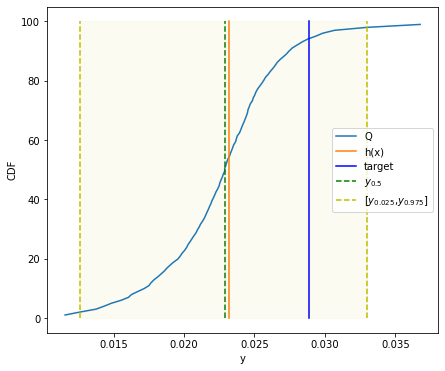

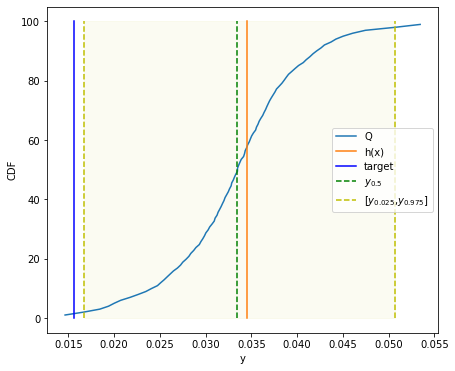

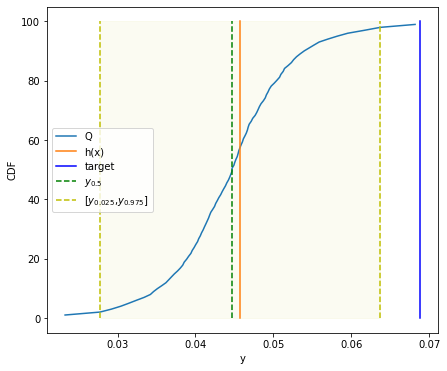

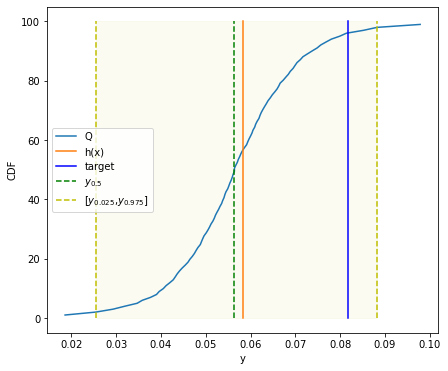

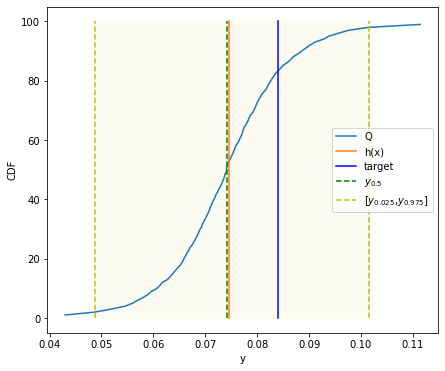

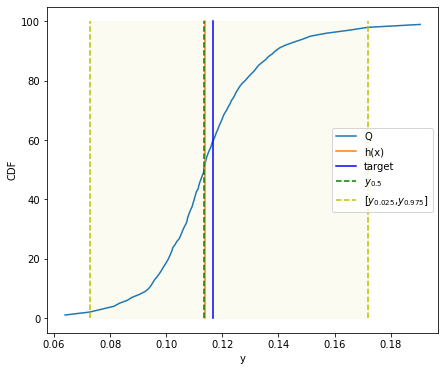

In [64]:
sorted_indexes = np.argsort(y_hat_full)
name="Mondrian Normalized OOB CPS"

mondrian_grid = cps_mondrian_oob.predict(y_hat=y_hat_full,
                                         bins=cps_test_bins_oob,
                                         sigmas=sigmas_test_knn_oob,
                                         lower_percentiles=np.linspace(1,50,50), 
                                         higher_percentiles=np.linspace(50,99,50),
                                         y_min=0, y_max=1)

no_bins = len(np.unique(cps_test_bins_oob))

bin_borders = np.linspace(0,len(y_hat_full),no_bins+1)
mid_bin_indexes = [sorted_indexes[int((bin_borders[i+1]+bin_borders[i])/2)] for i in range(no_bins)]

for test_index in mid_bin_indexes:
    Q = np.linspace(1,99,100)
    C = mondrian_grid[test_index,0:]

    plt.figure(figsize=(7,6))
    plt.plot(C,Q)
    plt.plot([y_hat_full[test_index],y_hat_full[test_index]],[0,100])
    plt.plot([y_test[test_index],y_test[test_index]],[0,100],"b")

    plt.xlabel("y")
    plt.ylabel("CDF")

    lower_index = np.where(Q<=2.5)[0][-1]
    mid_index = np.where(Q>=50)[0][0]

    upper_index = np.where(Q>=97.5)[0][0]

    low_percentile = C[lower_index]
    median = C[mid_index]
    high_percentile = C[upper_index]
    plt.plot([median,median],[0,100],"g--")
    plt.plot([low_percentile,low_percentile],[0,100],"y--")
    plt.legend(["Q","h(x)","target","$y_{0.5}$","[$y_{0.025}$,$y_{0.975}$]"])
    plt.plot([high_percentile,high_percentile],[0,100],"y--")
    rectangle = plt.Rectangle((low_percentile,0),abs(high_percentile-low_percentile),100, color="y", alpha=0.05)
    plt.gca().add_patch(rectangle)
    plt.show()

#### 3.13 Evaluate the CPS using the test set

Let us evaluate them using three confidence levels on the test set.
We could specify a subset of the metrics to use by the named
`metrics` argument of the `evaluate` method; here we use all, 
which is the default

Note that the arguments `sigmas` and `bins` can always be provided,
but they will be ignored by conformal regressors not using them,
e.g., both arguments will be ignored by the standard conformal regressors

Note that CRPS takes some time to compute, in particular when having 
larger calibration sets.

In [65]:
tic = time.time()

confidence_levels = [0.9,0.95,0.99]

names = list(all_cps.keys())
all_cps_results = {}

print("Evaluating confidence ", end="")

for confidence in confidence_levels:
    print(confidence,end=" ")
    for name in names:
        if "OOB" in name:
            all_cps_results[(name,confidence)] = all_cps[name].evaluate(y_hat=y_hat_full, 
                                                                        y=y_test, sigmas=sigmas_test_knn_oob, 
                                                                        bins=cps_test_bins_oob, confidence=confidence, 
                                                                        y_min=0, y_max=1)
        else:
            all_cps_results[(name,confidence)] =  all_cps[name].evaluate(y_hat=y_hat_proper, 
                                                                         y=y_test, sigmas=sigmas_test_knn, 
                                                                         bins=cps_test_bins, confidence=confidence, 
                                                                         y_min=0, y_max=1)
toc = time.time()
print("\nTime: {:.1f} s.".format(toc-tic))

cps_results_df = pd.DataFrame(columns=pd.MultiIndex.from_product([names,confidence_levels]),
                              index=list(list(all_cps_results.values())[0].keys()))

for key in all_cps_results.keys():
    cps_results_df[key] = all_cps_results[key].values()

display(cps_results_df.round(4))

Evaluating confidence 0.9 0.95 0.99 
Time: 16.2 s.


Standard CPS                 Standard OOB CPS                  \
                      0.90    0.95    0.99             0.90    0.95    0.99   
error               0.1044  0.0481  0.0076           0.1064  0.0518  0.0098   
efficiency          0.0418  0.0646  0.1398           0.0404  0.0608  0.1309   
CRPS                0.0075  0.0075  0.0075           0.0074  0.0074  0.0074   
time_fit            0.0015  0.0015  0.0015           0.0017  0.0017  0.0017   
time_evaluate       0.6755  0.6580  0.6010           1.6427  1.4254  1.3571   

              Normalized CPS                 Normalized OOB CPS          \
                        0.90    0.95    0.99               0.90    0.95   
error                 0.1041  0.0544  0.0114             0.1060  0.0541   
efficiency            0.0384  0.0521  0.0912             0.0379  0.0513   
CRPS                  0.0072  0.0072  0.0072             0.0071  0.0071   
time_fit              0.0005  0.0005  0.0005             0.0025  0.0025   
time_evaluate         0.6851  0.6453  0.6211             1.6312  1.4385   

                      Mondrian Normalized CPS                  \
                 0.99                    0.90    0.95    0.99   
error          0.0097                  0.1012  0.0514  0.0064   
efficiency     0.0943                  0.0415  0.0541  0.0921   
CRPS           0.0071                  0.0069  0.0069  0.0069   
time_fit       0.0025                  0.0013  0.0013  0.0013   
time_evaluate  1.4509                  0.5165  0.4648  0.4659   

              Mondrian Normalized OOB CPS                  
                                     0.90    0.95    0.99  
error                              0.1027  0.0534  0.0108  
efficiency                         0.0418  0.0551  0.0885  
CRPS                               0.0069  0.0069  0.0069  
time_fit                           0.0026  0.0026  0.0026  
time_evaluate                      0.6837  0.6081  0.6040